# Decision Trees and Random Forests

![](https://i.imgur.com/N8aIuRK.jpg)

In this notebook files, I performed the following tasks. 

- Explore uavsar-pits data
- Preparing the dataset for training
- Training and interpreting decision trees
- Training and interpreting random forests
- Overfitting, hyperparameter tuning & regularization
- Making predictions on single inputs



Import some required libraries before we begin.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import os
%matplotlib inline

from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

The file `uavsar_SWE_ENV.csv`contains the data. Let's load it into a Pandas dataframe.

In [2]:
raw_df = pd.read_csv('/home/naheemadebisi/PhD/snow-analytics/Radar-Backscatter/pits_data/uavsar_SWE_ENV.csv')

In [3]:
raw_df

,Unnamed: 0,Location,PitID,Density Mean (kg/m^3),Snow Depth (cm),SWE (mm),HH,HV,VH,VV,Temp_mean,Ground Condition,Ground Roughness,Ground Vegetation,Canopy
0,0,Boise River Basin,IDBRBL_20210127_1330,291.5,122.0,356.5,0.104028,0.101899,0.097273,0.116420,-3.500000,Frozen,Smooth,Bare,Sparse (5-20%)
1,1,Boise River Basin,IDBRBT_20210127_1500,292.5,69.0,202.0,0.415091,0.119713,0.097183,0.217637,NaN,Frozen,Smooth,Bare | Deadfall,Closed (>70%)
2,2,Boise River Basin,IDBRLO_20210126_1205,292.0,78.0,227.5,0.163230,0.044706,0.053978,0.143295,-2.755556,Moist,Rough,Shrub,No Trees
3,3,Boise River Basin,IDBRLT_20210126_1335,248.0,22.0,55.0,0.243080,0.121562,0.119280,0.257768,-2.000000,Moist,Rough,Deadfall,Closed (>70%)
4,4,Boise River Basin,IDBRBS_20210128_1200,252.5,141.0,355.0,0.367296,0.087664,0.057098,0.177950,-3.913333,Frozen,Smooth,Bare,Sparse (5-20%)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,281,Senator Beck,COSBSA_20210303_1305,303.0,145.0,439.0,0.228256,0.067750,0.060650,0.208844,-3.487500,Moist,Smooth,Grass,No Trees
282,282,Senator Beck,COSBSA_20210127_1210,236.0,127.0,300.0,0.156946,0.038421,0.036239,0.141845,-5.614286,Frozen,Rough,Grass,No Trees
283,283,Senator Beck,COSBSA_20210317_1241,283.0,192.0,544.5,0.149433,0.045109,0.052350,0.127968,-2.757143,Moist,Smooth,Grass,No Trees
284,284,Senator Beck,COSBSA_20210310_1322,310.5,158.0,491.0,0.217294,0.044286,0.047237,0.211791,-3.123529,Frozen,Smooth,Grass,No Trees


In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             286 non-null    int64  
 1   Location               286 non-null    object 
 2   PitID                  286 non-null    object 
 3   Density Mean (kg/m^3)  286 non-null    float64
 4   Snow Depth (cm)        286 non-null    float64
 5   SWE (mm)               286 non-null    float64
 6   HH                     277 non-null    float64
 7   HV                     277 non-null    float64
 8   VH                     277 non-null    float64
 9   VV                     277 non-null    float64
 10  Temp_mean              272 non-null    float64
 11  Ground Condition       284 non-null    object 
 12  Ground Roughness       284 non-null    object 
 13  Ground Vegetation      282 non-null    object 
 14  Canopy                 285 non-null    object 
dtypes: flo

In [5]:
raw_df.isna().sum()

Unnamed: 0                0
Location                  0
PitID                     0
Density Mean (kg/m^3)     0
Snow Depth (cm)           0
SWE (mm)                  0
HH                        9
HV                        9
VH                        9
VV                        9
Temp_mean                14
Ground Condition          2
Ground Roughness          2
Ground Vegetation         4
Canopy                    1
dtype: int64

There is not a lot of missing data so we can safely drop the missing rows.

In [6]:
raw_df.dropna(inplace=True)

### Training, Validation and Test Sets

In [7]:
#train-validation-test split
train_df , test_df = train_test_split(raw_df, test_size= 0.2, random_state= 20221104)
train_df , val_df = train_test_split(train_df, test_size= 0.2, random_state= 20221105)

print(f"lenth of the training data is {len(train_df)}")
print(f"lenth of the testdata is {len(test_df)}")
print(f"lenth of the valdata is {len(val_df)}")

lenth of the training data is 166
lenth of the testdata is 53
lenth of the valdata is 42


### Input and Target Columns

Let's identify the input and target columns.

In [8]:
input_cols = ['Density Mean (kg/m^3)', 'Snow Depth (cm)', 'SWE (mm)', 'Temp_mean',
       'Ground Condition', 'Ground Roughness', 'Canopy']
target_col = 'HH'

In [9]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

In [10]:
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

In [11]:
test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

Let's also identify the numeric and categorical columns.

In [12]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

In [13]:
print(numeric_cols)

['Density Mean (kg/m^3)', 'Snow Depth (cm)', 'SWE (mm)', 'Temp_mean']


In [14]:
print(categorical_cols)

['Ground Condition', 'Ground Roughness', 'Canopy']


### Scaling Numeric Features

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
scaler = MinMaxScaler().fit(raw_df[numeric_cols])

In [17]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [18]:
val_inputs.describe().loc[['min', 'max']]

,Density Mean (kg/m^3),Snow Depth (cm),SWE (mm),Temp_mean
min,0.049936,0.072519,0.011488,0.0
max,0.830986,1.000000,1.000000,1.0


### Encoding Categorical Data

In [19]:
from sklearn.preprocessing import OneHotEncoder

In [20]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(raw_df[categorical_cols])

In [21]:
encoded_cols = list(encoder.get_feature_names(categorical_cols))

/home/naheemadebisi/miniconda3/envs/earth-analytics-python/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [22]:
encoded_cols

['Ground Condition_Frozen',
 'Ground Condition_Moist',
 'Ground Condition_Saturated',
 'Ground Roughness_Rough',
 'Ground Roughness_Rugged',
 'Ground Roughness_Smooth',
 'Canopy_Closed (>70%)',
 'Canopy_No Trees',
 'Canopy_Open (20-70%)',
 'Canopy_Sparse (5-20%)']

In [23]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

In [24]:
test_inputs

,Density Mean (kg/m^3),Snow Depth (cm),SWE (mm),Temp_mean,Ground Condition,Ground Roughness,Canopy,Ground Condition_Frozen,Ground Condition_Moist,Ground Condition_Saturated,Ground Roughness_Rough,Ground Roughness_Rugged,Ground Roughness_Smooth,Canopy_Closed (>70%),Canopy_No Trees,Canopy_Open (20-70%),Canopy_Sparse (5-20%)
205,0.656850,0.354962,0.351751,0.880237,Moist,Rough,No Trees,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
94,0.541613,0.362595,0.302516,0.784142,Frozen,Rough,Closed (>70%),1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
165,0.181818,0.351145,0.117615,0.507692,Frozen,Smooth,Sparse (5-20%),1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
187,0.428937,0.351145,0.237965,0.695148,Frozen,Rough,No Trees,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
269,0.425096,0.213740,0.142779,0.702564,Frozen,Smooth,Open (20-70%),1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
282,0.421255,0.400763,0.268053,0.654505,Frozen,Rough,No Trees,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
76,0.476312,0.290076,0.214442,0.729231,Frozen,Rough,Open (20-70%),1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
32,0.467350,0.416031,0.304158,0.808000,Frozen,Rough,Sparse (5-20%),1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
129,0.358515,0.118321,0.062363,0.753846,Frozen,Smooth,Sparse (5-20%),1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
156,0.249680,0.103053,0.030088,0.692308,Frozen,Smooth,No Trees,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


As a final step, let's drop the textual categorical columns, so that we're left with just numeric data.

In [25]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

In [26]:
X_test

,Density Mean (kg/m^3),Snow Depth (cm),SWE (mm),Temp_mean,Ground Condition_Frozen,Ground Condition_Moist,Ground Condition_Saturated,Ground Roughness_Rough,Ground Roughness_Rugged,Ground Roughness_Smooth,Canopy_Closed (>70%),Canopy_No Trees,Canopy_Open (20-70%),Canopy_Sparse (5-20%)
205,0.656850,0.354962,0.351751,0.880237,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
94,0.541613,0.362595,0.302516,0.784142,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
165,0.181818,0.351145,0.117615,0.507692,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
187,0.428937,0.351145,0.237965,0.695148,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
269,0.425096,0.213740,0.142779,0.702564,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
282,0.421255,0.400763,0.268053,0.654505,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
76,0.476312,0.290076,0.214442,0.729231,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
32,0.467350,0.416031,0.304158,0.808000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
129,0.358515,0.118321,0.062363,0.753846,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
156,0.249680,0.103053,0.030088,0.692308,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


## Training and Visualizing Decision Trees

A decision tree in general parlance represents a hierarchical series of binary decisions:

<img src="https://i.imgur.com/qSH4lqz.png" width="480">

A decision tree in machine learning works in exactly the same way, and except that we let the computer figure out the optimal structure & hierarchy of decisions, instead of coming up with criteria manually.

### Training

We can use `DecisionTreeRegressor` from `sklearn.tree` to train a decision tree.

In [27]:
from sklearn.tree import DecisionTreeRegressor

In [28]:
model = DecisionTreeRegressor(random_state=42)

In [29]:
%%time
model.fit(X_train, train_targets)

CPU times: user 1.69 ms, sys: 3.19 ms, total: 4.88 ms
Wall time: 13.8 ms


DecisionTreeRegressor(random_state=42)

An optimal decision tree has now been created using the training data.

### Evaluation

Let's evaluate the decision tree using the accuracy score.

In [30]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

In [31]:
train_preds = model.predict(X_train)

In [32]:
train_preds

array([0.14536801, 0.13888408, 0.07807567, 0.16321391, 0.10213241,
       0.17797856, 0.1494329 , 0.22902824, 0.40978894, 0.46206555,
       0.24283507, 0.22825639, 0.15762739, 0.11919729, 0.16600448,
       0.28163517, 0.08310531, 0.3515431 , 0.14336039, 0.04338513,
       0.18909195, 0.22449262, 0.11126077, 0.39702013, 0.24308047,
       0.136026  , 0.16322964, 0.11156106, 0.12292591, 0.27879864,
       0.33680159, 0.13416624, 0.34310979, 0.33423874, 0.33674842,
       0.10088841, 0.14461866, 0.11175012, 0.30054376, 0.17081177,
       0.29503962, 0.09529513, 0.05881939, 0.17142424, 0.08141255,
       0.32182059, 0.25820592, 0.34460306, 0.21729352, 0.04589514,
       0.34856346, 0.05475857, 0.27352935, 0.14439975, 0.27968663,
       0.17445898, 0.06257146, 0.35859609, 0.10999326, 0.11316983,
       0.24364866, 0.41845417, 0.16160883, 0.28076422, 0.14112742,
       0.45120004, 0.06565071, 0.22888796, 0.3672955 , 0.21987982,
       0.10053085, 0.16410549, 0.0492042 , 0.15969768, 0.06489

The decision tree also returns probabilities for each prediction.

In [33]:
r2_score(train_targets, train_preds)

1.0

In [37]:
#model.score(X_train, train_preds)

1.0

The training set accuracy is 100%! But we can't rely solely on the training set accuracy, we must evaluate the model on the validation set too. 

We can make predictions and compute accuracy in one step using `model.score`

In [35]:
model.score(X_val, val_targets)

0.3071236034761726

Although the training accuracy is 100%, the accuracy on the validation set is just about 30%.

It appears that the model has learned the training examples perfect, and doesn't generalize well to previously unseen examples. This phenomenon is called "overfitting", and reducing overfitting is one of the most important parts of any machine learning project.

### Visualization

We can visualize the decision tree _learned_ from the training data.

In [38]:
from sklearn.tree import plot_tree, export_text

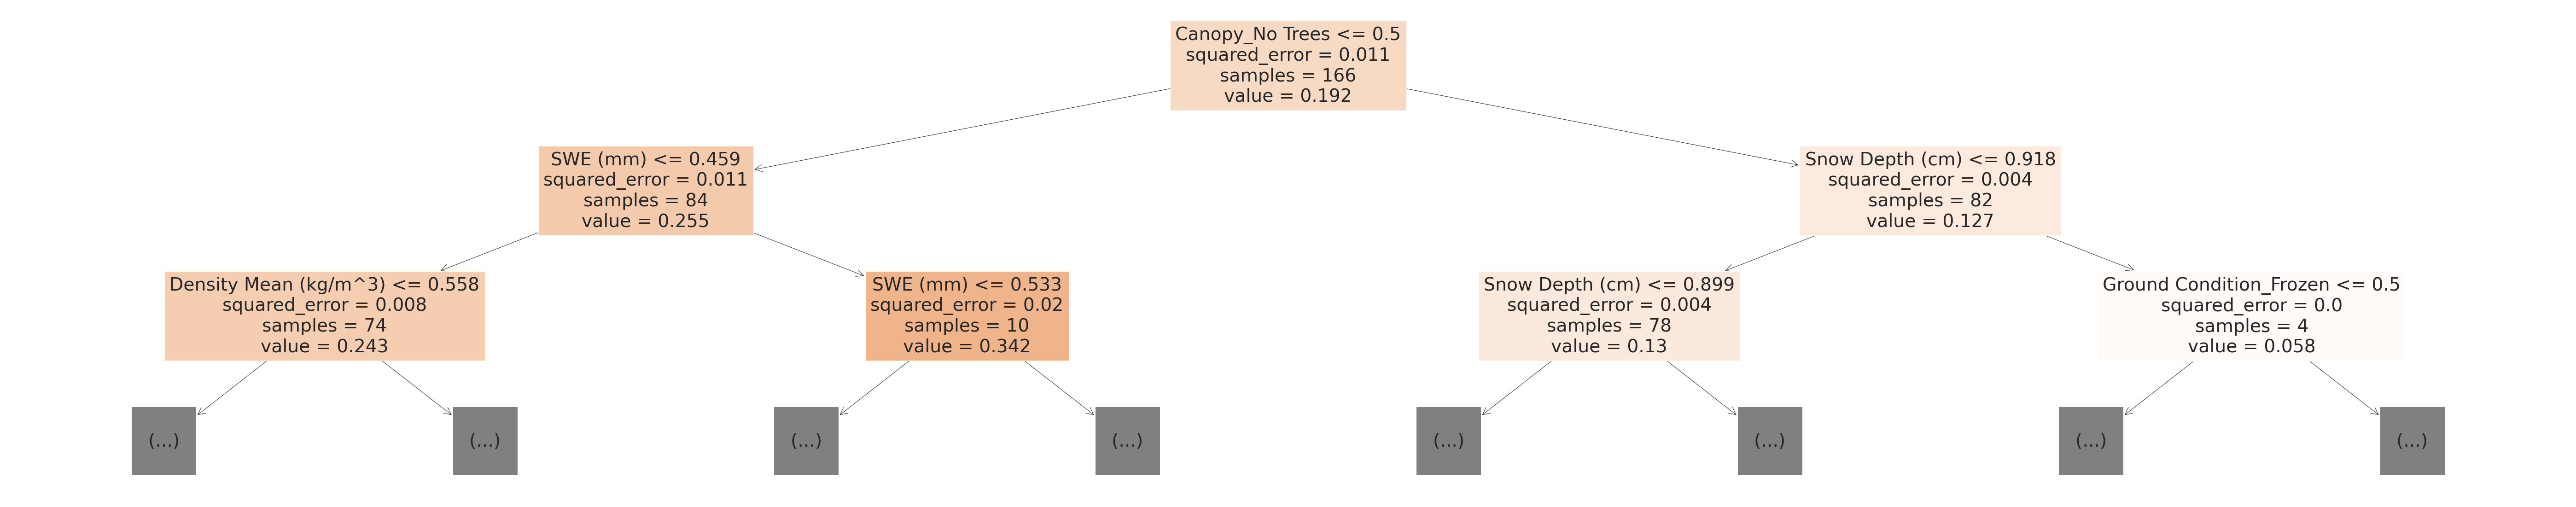

In [40]:
plt.figure(figsize=(100,20))
plot_tree(model, feature_names=X_train.columns, max_depth=2, filled=True);

Let's check the depth of the tree that was created.

In [41]:
model.tree_.max_depth

21

We can also display the tree as text, which can be easier to follow for deeper trees.

In [42]:
tree_text = export_text(model, max_depth=10, feature_names=list(X_train.columns))
print(tree_text[:5000])

|--- Canopy_No Trees <= 0.50
|   |--- SWE (mm) <= 0.46
|   |   |--- Density Mean (kg/m^3) <= 0.56
|   |   |   |--- Ground Roughness_Smooth <= 0.50
|   |   |   |   |--- Canopy_Closed (>70%) <= 0.50
|   |   |   |   |   |--- Temp_mean <= 0.71
|   |   |   |   |   |   |--- SWE (mm) <= 0.22
|   |   |   |   |   |   |   |--- Temp_mean <= 0.53
|   |   |   |   |   |   |   |   |--- value: [0.31]
|   |   |   |   |   |   |   |--- Temp_mean >  0.53
|   |   |   |   |   |   |   |   |--- Density Mean (kg/m^3) <= 0.51
|   |   |   |   |   |   |   |   |   |--- Temp_mean <= 0.63
|   |   |   |   |   |   |   |   |   |   |--- value: [0.35]
|   |   |   |   |   |   |   |   |   |--- Temp_mean >  0.63
|   |   |   |   |   |   |   |   |   |   |--- value: [0.34]
|   |   |   |   |   |   |   |   |--- Density Mean (kg/m^3) >  0.51
|   |   |   |   |   |   |   |   |   |--- value: [0.34]
|   |   |   |   |   |   |--- SWE (mm) >  0.22
|   |   |   |   |   |   |   |--- value: [0.39]
|   |   |   |   |   |--- Temp_mean >  0.71


### Feature Importance

A decision tree assigns an "importance" value to each feature. These values can be used to interpret the results given by a decision tree.

In [43]:
model.feature_importances_

array([9.53546245e-02, 1.36606220e-01, 2.38502533e-01, 6.34030040e-02,
       4.91900818e-03, 1.41552343e-02, 1.26993811e-03, 3.20182837e-04,
       2.01118989e-07, 3.38577628e-02, 1.71580493e-02, 3.58997153e-01,
       3.54560882e-02, 0.00000000e+00])

Let's turn this into a dataframe and visualize the most important features.

In [44]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [45]:
importance_df.head(10)

,feature,importance
11,Canopy_No Trees,0.358997
2,SWE (mm),0.238503
1,Snow Depth (cm),0.136606
0,Density Mean (kg/m^3),0.095355
3,Temp_mean,0.063403
12,Canopy_Open (20-70%),0.035456
9,Ground Roughness_Smooth,0.033858
10,Canopy_Closed (>70%),0.017158
5,Ground Condition_Moist,0.014155
4,Ground Condition_Frozen,0.004919


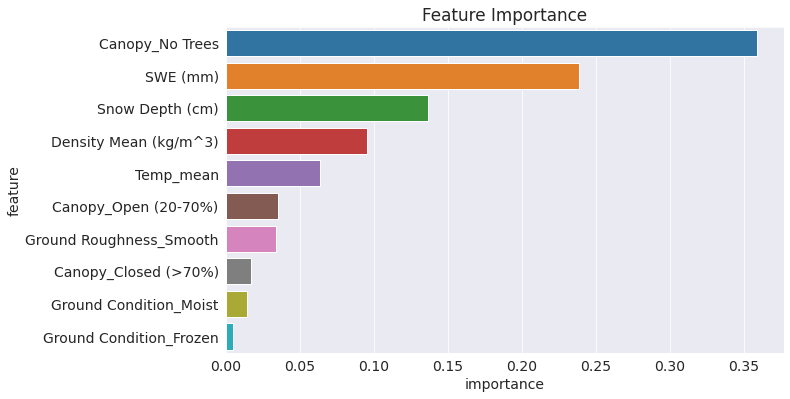

In [46]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

## Hyperparameter Tuning and Overfitting

As we saw in the previous section, our decision tree memorized all training examples, leading to a 100% training accuracy, while the validation accuracy was not that good. This phenomenon is called overfitting. Let's reduce overfitting. The process of reducing overfitting is known as _regularlization_.


The `DecisionTreeRegressor` accepts several arguments, some of which can be modified to reduce overfitting.

In [47]:
?DecisionTreeRegressor

Init signature:
DecisionTreeRegressor(
    *,
    criterion='squared_error',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    ccp_alpha=0.0,
)
Docstring:     
A decision tree regressor.

Read more in the :ref:`User Guide <tree>`.

Parameters
----------
criterion : {"squared_error", "friedman_mse", "absolute_error",             "poisson"}, default="squared_error"
    The function to measure the quality of a split. Supported criteria
    are "squared_error" for the mean squared error, which is equal to
    variance reduction as feature selection criterion and minimizes the L2
    loss using the mean of each terminal node, "friedman_mse", which uses
    mean squared error with Friedman's improvement score for potential
    splits, "absolute_error" for the mean absolute error, which minimizes
    the L1 loss usi

These arguments are called hyperparameters because they must be configured manually (as opposed to the parameters within the model which are _learned_ from the data. We'll explore a couple of hyperparameters:

- `max_depth`
- `max_leaf_nodes`

### `max_depth`

By reducing the maximum depth of the decision tree, we can prevent the tree from memorizing all training examples, which may lead to better generalization

In [48]:
model = DecisionTreeRegressor(max_depth=3, random_state=42)

In [49]:
model.fit(X_train, train_targets)

DecisionTreeRegressor(max_depth=3, random_state=42)

We can compute the accuracy of the model on the training and validation sets using `model.score`

In [50]:
model.score(X_train, train_targets)

0.5394809034662191

In [51]:
model.score(X_val, val_targets)

0.4125293780299405

Great, while the training accuracy of the model has gone down, the validation accuracy of the model has increased significantly.

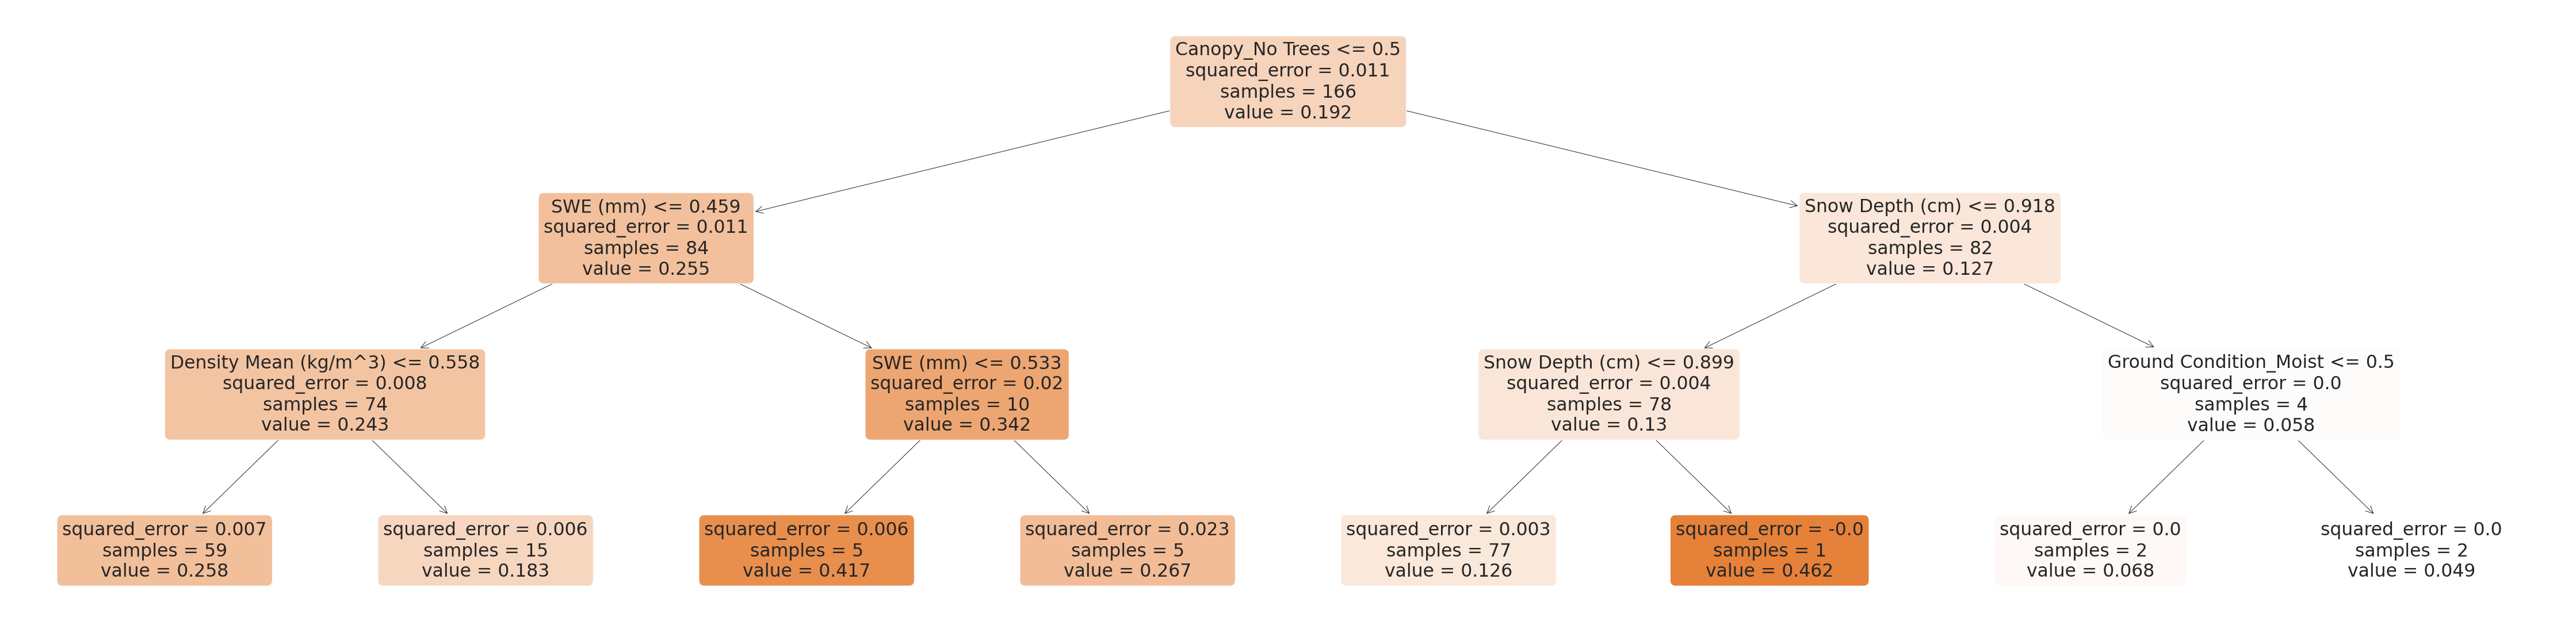

In [53]:
plt.figure(figsize=(80,20))
plot_tree(model, feature_names=X_train.columns, filled=True, rounded=True);

The uniqueness of the prediction depends on the depth of splitting.

In [56]:
train_preds = model.predict(X_train)
np.unique(train_preds)

array([0.04907185, 0.06782968, 0.12609829, 0.18335028, 0.25827842,
       0.26730778, 0.41747955, 0.46206555])

In [57]:
print(export_text(model, feature_names=list(X_train.columns)))

|--- Canopy_No Trees <= 0.50
|   |--- SWE (mm) <= 0.46
|   |   |--- Density Mean (kg/m^3) <= 0.56
|   |   |   |--- value: [0.26]
|   |   |--- Density Mean (kg/m^3) >  0.56
|   |   |   |--- value: [0.18]
|   |--- SWE (mm) >  0.46
|   |   |--- SWE (mm) <= 0.53
|   |   |   |--- value: [0.42]
|   |   |--- SWE (mm) >  0.53
|   |   |   |--- value: [0.27]
|--- Canopy_No Trees >  0.50
|   |--- Snow Depth (cm) <= 0.92
|   |   |--- Snow Depth (cm) <= 0.90
|   |   |   |--- value: [0.13]
|   |   |--- Snow Depth (cm) >  0.90
|   |   |   |--- value: [0.46]
|   |--- Snow Depth (cm) >  0.92
|   |   |--- Ground Condition_Moist <= 0.50
|   |   |   |--- value: [0.07]
|   |   |--- Ground Condition_Moist >  0.50
|   |   |   |--- value: [0.05]



Let's experiment with different depths using a helper function.

In [58]:
def max_depth_error(md):
    model = DecisionTreeRegressor(max_depth=md, random_state=42)
    model.fit(X_train, train_targets)
    train_acc = model.score(X_train, train_targets)
    val_acc = model.score(X_val, val_targets)
    return {'Max Depth': md, 'Training Error': 1- train_acc, 'Validation Error': 1- val_acc}

In [59]:
%%time
errors_df = pd.DataFrame([max_depth_error(md) for md in range(1, 21)])

CPU times: user 120 ms, sys: 6.63 ms, total: 127 ms
Wall time: 126 ms


In [60]:
errors_df

,Max Depth,Training Error,Validation Error
0,1,0.641003,0.555111
1,2,0.584741,0.568941
2,3,0.460519,0.587471
3,4,0.338798,0.623617
4,5,0.242701,0.693855
5,6,0.181198,0.635235
6,7,0.120890,0.600812
7,8,0.086044,0.640915
8,9,0.054247,0.641013
9,10,0.033177,0.680401


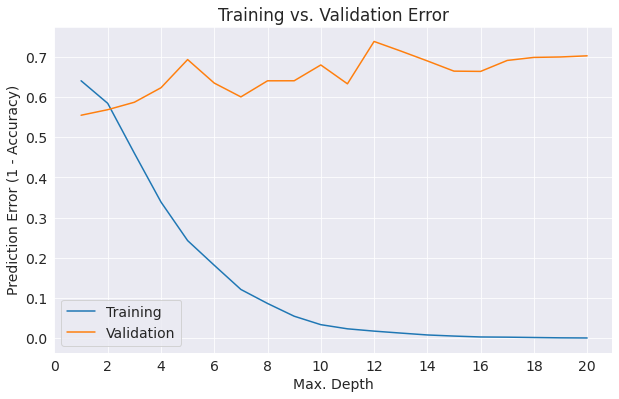

In [61]:
plt.figure()
plt.plot(errors_df['Max Depth'], errors_df['Training Error'])
plt.plot(errors_df['Max Depth'], errors_df['Validation Error'])
plt.title('Training vs. Validation Error')
plt.xticks(range(0,21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation'])

The plot above shows that optimal performance of the model is on the very simple model. Even for simple model, overfitting occurs. Decision Trees is perhaps too complex for the problem. This is because we have too small datasest to train the model. With a fewer or smaller number of datasets, it becomes easier for models to overfit a dataset even if the model is simpler.

The common pattern expected is below:

<img src="https://i.imgur.com/EJCrSZw.png" width="480">





You'll often need to tune hyperparameters carefully to find the optimal fit. In the above case, it appears that a maximum depth of 3 results in the lowest validation error.

In [65]:
model = DecisionTreeRegressor(max_depth=3, random_state=42).fit(X_train, train_targets)
model.score(X_val, val_targets)

0.4125293780299405

### `max_leaf_nodes`

Another way to control the size of complexity of a decision tree is to limit the number of leaf nodes. This allows branches of the tree to have varying depths. 

In [73]:
model = DecisionTreeClassifier(max_leaf_nodes=128, random_state=42)

In [74]:
model.fit(X_train, train_targets)

DecisionTreeClassifier(max_leaf_nodes=128, random_state=42)

In [75]:
model.score(X_train, train_targets)

0.8480421869317493

In [76]:
model.score(X_val, val_targets)

0.8442342290058615

In [77]:
model.tree_.max_depth

12

Notice that the model was able to achieve a greater depth of 12 for certain paths while keeping other paths shorter.

In [78]:
model_text = export_text(model, feature_names=list(X_train.columns))
print(model_text[:3000])

|--- Humidity3pm <= 0.72
|   |--- Rainfall <= 0.00
|   |   |--- Sunshine <= 0.52
|   |   |   |--- Pressure3pm <= 0.58
|   |   |   |   |--- WindGustSpeed <= 0.36
|   |   |   |   |   |--- Humidity3pm <= 0.28
|   |   |   |   |   |   |--- class: No
|   |   |   |   |   |--- Humidity3pm >  0.28
|   |   |   |   |   |   |--- Sunshine <= 0.05
|   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |--- Sunshine >  0.05
|   |   |   |   |   |   |   |--- Pressure3pm <= 0.43
|   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |--- Pressure3pm >  0.43
|   |   |   |   |   |   |   |   |--- Humidity3pm <= 0.57
|   |   |   |   |   |   |   |   |   |--- WindDir9am_NE <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- WindDir9am_NNE <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |   |   |--- WindDir9am_NNE >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |   |--- WindD

> **EXERCISE**: Find the combination of `max_depth` and `max_leaf_nodes` that results in the highest validation accuracy.

> **EXERCISE**: Explore and experiment with other arguments of `DecisionTree`. Refer to the docs for details: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

> **EXERCISE**: A more advanced technique (but less commonly used technique) for reducing overfitting in decision trees is known as cost-complexity pruning. Learn more about it here: https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html . Implement cost complexity pruning. Do you see any improvement in the validation accuracy?

Let's save our work before continuing.

In [79]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/aakashns/sklearn-decision-trees-random-forests


'https://jovian.ai/aakashns/sklearn-decision-trees-random-forests'

## Training a Random Forest

While tuning the hyperparameters of a single decision tree may lead to some improvements, a much more effective strategy is to combine the results of several decision trees trained with slightly different parameters. This is called a random forest model. 

The key idea here is that each decision tree in the forest will make different kinds of errors, and upon averaging, many of their errors will cancel out. This idea is also commonly known as the "wisdom of the crowd":

<img src="https://i.imgur.com/4Dg0XK4.png" width="480">

A random forest works by averaging/combining the results of several decision trees:

<img src="https://1.bp.blogspot.com/-Ax59WK4DE8w/YK6o9bt_9jI/AAAAAAAAEQA/9KbBf9cdL6kOFkJnU39aUn4m8ydThPenwCLcBGAsYHQ/s0/Random%2BForest%2B03.gif" width="640">


We'll use the `RandomForestClassifier` class from `sklearn.ensemble`.

In [80]:
from sklearn.ensemble import RandomForestClassifier

In [81]:
model = RandomForestClassifier(n_jobs=-1, random_state=42)

`n_jobs` allows the random forest to use mutiple parallel workers to train decision trees, and `random_state=42` ensures that the we get the same results for each execution.

In [82]:
%%time
model.fit(X_train, train_targets)

CPU times: user 35.7 s, sys: 203 ms, total: 35.9 s
Wall time: 18.6 s


RandomForestClassifier(n_jobs=-1, random_state=42)

In [83]:
model.score(X_train, train_targets)

0.9999494888269285

In [84]:
model.score(X_val, val_targets)

0.8566537055307295

Once again, the training accuracy is almost 100%, but this time the validation accuracy is much better. In fact, it is better than the best single decision tree we had trained so far. Do you see the power of random forests?

This general technique of combining the results of many models is called "ensembling", it works because most errors of individual models cancel out on averaging. Here's what it looks like visually:

<img src="https://i.imgur.com/qJo8D8b.png" width="640">


We can also look at the probabilities for the predictions. The probability of a class is simply the fraction of trees which that predicted the given class.

In [85]:
train_probs = model.predict_proba(X_train)
train_probs

array([[0.93, 0.07],
       [1.  , 0.  ],
       [0.99, 0.01],
       ...,
       [0.99, 0.01],
       [1.  , 0.  ],
       [0.96, 0.04]])

We can can access individual decision trees using `model.estimators_`

In [86]:
model.estimators_[0]

DecisionTreeClassifier(max_features='auto', random_state=1608637542)

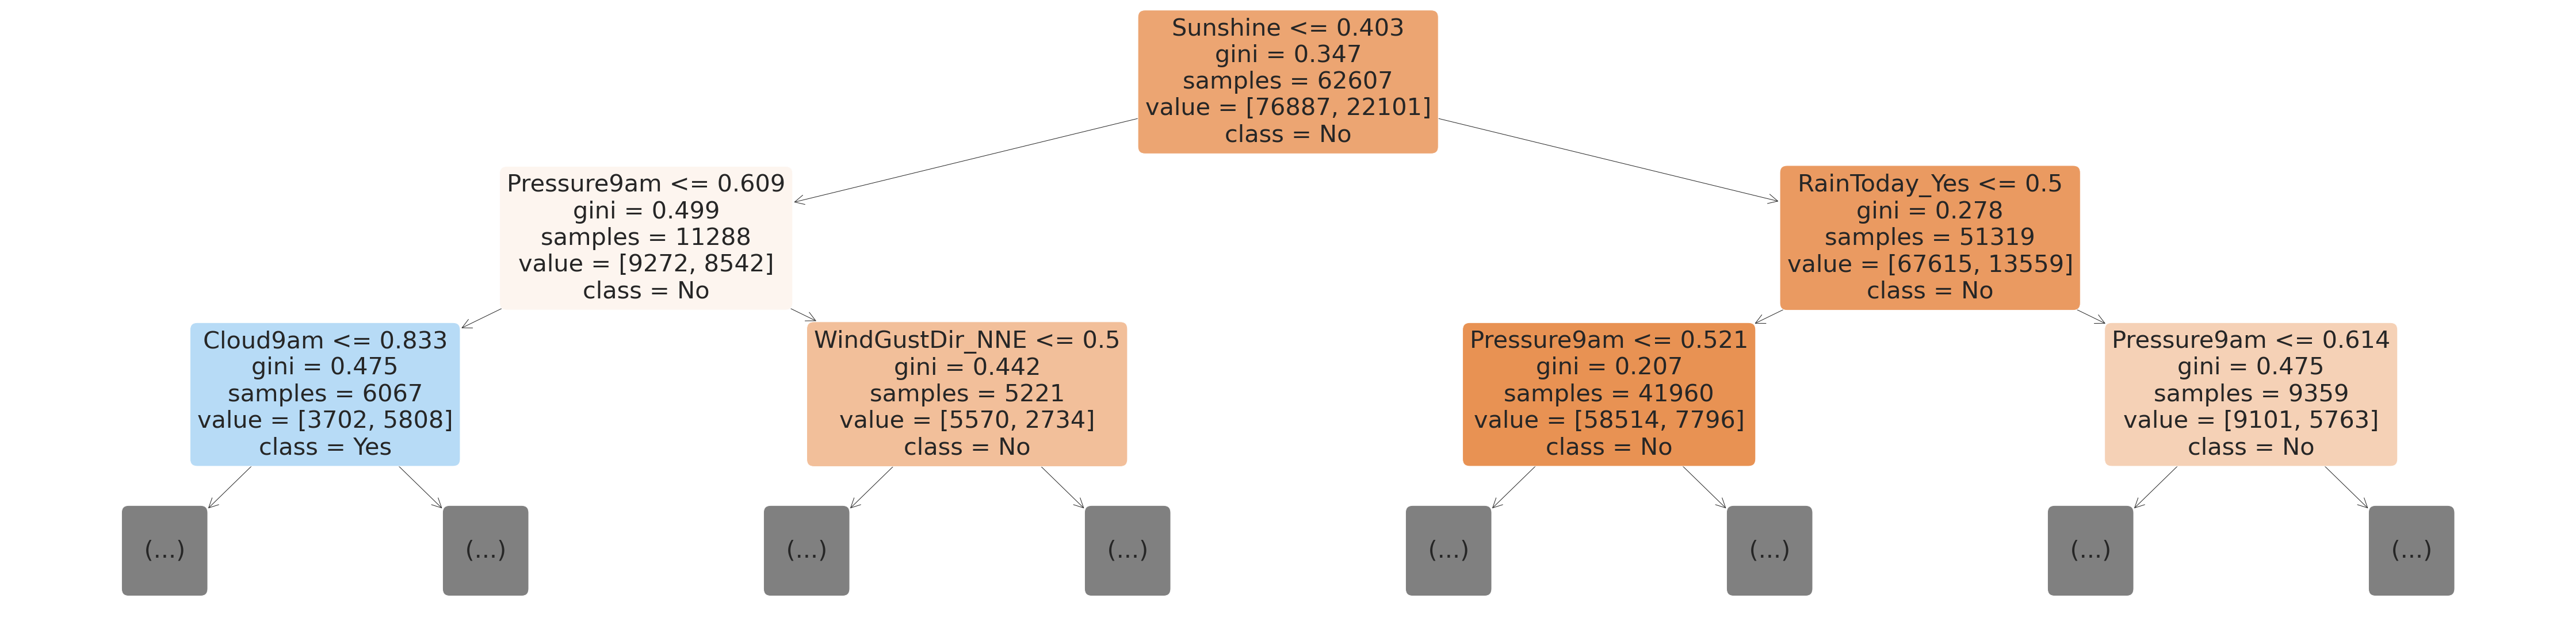

In [87]:
plt.figure(figsize=(80,20))
plot_tree(model.estimators_[0], max_depth=2, feature_names=X_train.columns, filled=True, rounded=True, class_names=model.classes_);

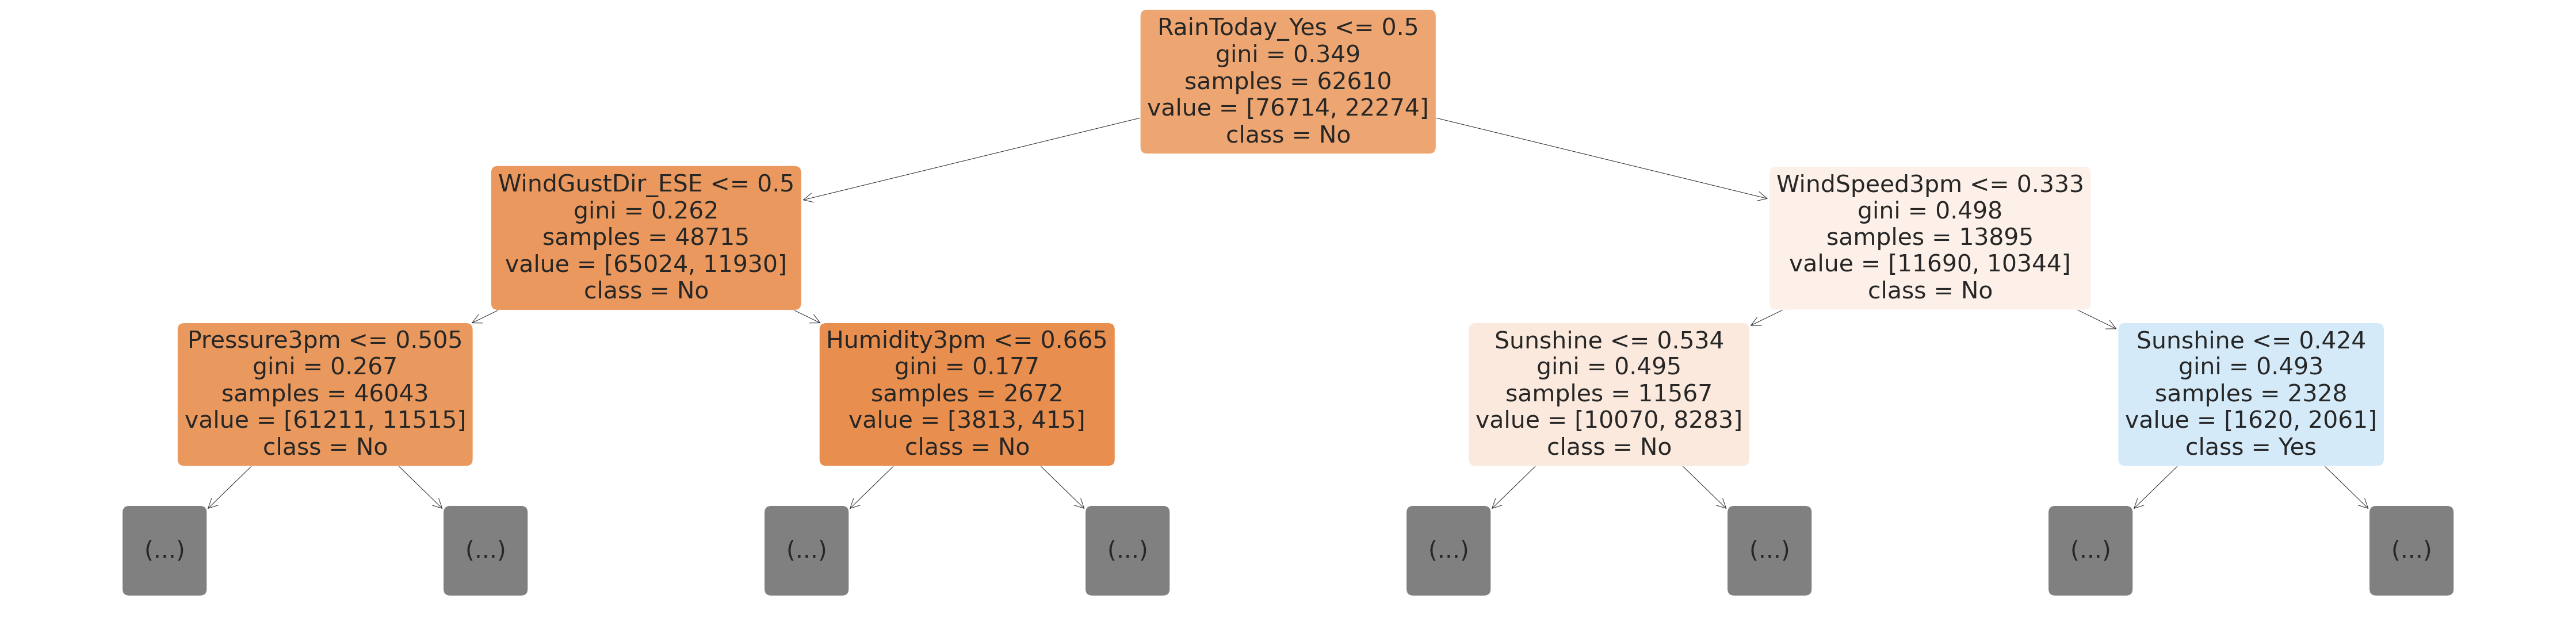

In [88]:
plt.figure(figsize=(80,20))
plot_tree(model.estimators_[20], max_depth=2, feature_names=X_train.columns, filled=True, rounded=True, class_names=model.classes_);

In [89]:
len(model.estimators_)

100

> **EXERCISE**: Verify that none of the individual decision trees have a better validation accuracy than the random forest. 

Just like decision tree, random forests also assign an "importance" to each feature, by combining the importance values from individual trees.

In [90]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [91]:
importance_df.head(10)

,feature,importance
9,Humidity3pm,0.139904
4,Sunshine,0.053696
11,Pressure3pm,0.052713
8,Humidity9am,0.050051
2,Rainfall,0.048077
10,Pressure9am,0.047944
5,WindGustSpeed,0.047477
15,Temp3pm,0.044379
1,MaxTemp,0.041865
0,MinTemp,0.041199


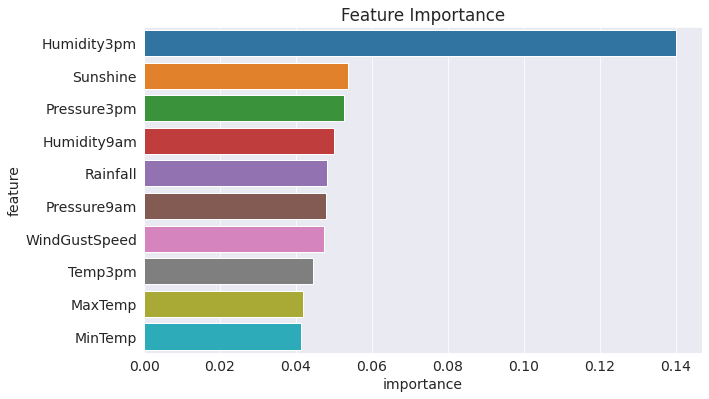

In [92]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

Notice that the distribution is a lot less skewed than that for a single decision tree.

Let's save our work before continuing.

In [93]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/aakashns/sklearn-decision-trees-random-forests


'https://jovian.ai/aakashns/sklearn-decision-trees-random-forests'

## Hyperparameter Tuning with Random Forests

Just like decision trees, random forests also have several hyperparameters. In fact many of these hyperparameters are applied to the underlying decision trees. 

Let's study some the hyperparameters for random forests. You can learn more about them here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [ ]:
?RandomForestClassifier

Let's create a base model with which we can compare models with tuned hyperparameters.

In [94]:
base_model = RandomForestClassifier(random_state=42, n_jobs=-1).fit(X_train, train_targets)

In [95]:
base_train_acc = base_model.score(X_train, train_targets)
base_val_acc = base_model.score(X_val, val_targets)

In [96]:
base_accs = base_train_acc, base_val_acc
base_accs

(0.9999494888269285, 0.8566537055307295)

We can use this as a benchmark for hyperparmeter tuning.

### `n_estimators`

This argument controls the number of decision trees in the random forest. The default value is 100. For larger datasets, it helps to have a greater number of estimators. As a general rule, try to have as few estimators as needed. 


**10 estimators**

In [97]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=10)

In [98]:
model.fit(X_train, train_targets)

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)

In [99]:
model.score(X_train, train_targets), model.score(X_val, val_targets)

(0.986958015112943, 0.8485868492832686)

In [100]:
base_accs

(0.9999494888269285, 0.8566537055307295)

**500 estimators**

In [101]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=500)
model.fit(X_train, train_targets)

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)

In [102]:
model.score(X_train, train_targets)

0.9999797955307714

In [103]:
model.score(X_val, val_targets)

0.8577563693343393

In [104]:
base_accs

(0.9999494888269285, 0.8566537055307295)

> **EXERCISE**: Vary the value of `n_estimators` and plot the graph between training error and validation error. What is the optimal value of `n_estimators`?

### `max_depth` and `max_leaf_nodes`

These arguments are passed directly to each decision tree, and control the maximum depth and max. no leaf nodes of each tree respectively. By default, no maximum depth is specified, which is why each tree has a training accuracy of 100%. You can specify a `max_depth` to reduce overfitting.

<img src="https://i.imgur.com/EJCrSZw.png" width="480">


Let's define a helper function `test_params` to make it easy to test hyperparameters.

In [105]:
def test_params(**params):
    model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(X_train, train_targets)
    return model.score(X_train, train_targets), model.score(X_val, val_targets)

Let's test a few values of `max_depth` and `max_leaf_nodes`.

In [106]:
test_params(max_depth=5)

(0.8197862367155615, 0.8240961058557251)

In [107]:
test_params(max_depth=26)

(0.9814826039519942, 0.8572340549010504)

In [108]:
test_params(max_leaf_nodes=2**5)

(0.8314341132258456, 0.833904010214149)

In [109]:
test_params(max_leaf_nodes=2**20)

(0.9999494888269285, 0.8556671116011839)

In [110]:
base_accs # no max depth or max leaf nodes

(0.9999494888269285, 0.8566537055307295)

The optimal values of `max_depth` and `max_leaf_nodes` lies somewhere between 0 and unbounded.

> **EXERCISE**: Vary the value of `max_depth` and plot the graph between training error and validation error. What is the optimal value of `max_depth`? Do the same for `max_leaf_nodes`.

### `max_features`

Instead of picking all features (columns) for every split, we can specify that only a fraction of features be chosen randomly to figure out a split.

<img src="https://i.imgur.com/FXGWMDY.png" width="720">

Notice that the default value `auto` causes only $\sqrt{n}$ out of total features ( $n$ ) to be chosen randomly at each split. This is the reason each decision tree in the forest is different. While it may seem counterintuitive, choosing all features for every split of every tree will lead to identical trees, so the random forest will not generalize well. 

In [111]:
test_params(max_features='log2')

(0.9999595910615429, 0.8558992513493123)

In [112]:
test_params(max_features=3)

(0.9999494888269285, 0.8543323080494458)

In [113]:
test_params(max_features=6)

(0.9999595910615429, 0.8558992513493123)

In [114]:
base_accs

(0.9999494888269285, 0.8566537055307295)

> **EXERCISE**: Find the optimal values of `max_features` for this dataset.

### `min_samples_split` and `min_samples_leaf`

By default, the decision tree classifier tries to split every node that has 2 or more. You can increase the values of these arguments to change this behavior and reduce overfitting, especially for very large datasets.

In [115]:
test_params(min_samples_split=3, min_samples_leaf=2)

(0.9625005051117307, 0.8565956705936975)

In [116]:
test_params(min_samples_split=100, min_samples_leaf=60)

(0.8495676243585081, 0.8451047530613429)

In [117]:
base_accs

(0.9999494888269285, 0.8566537055307295)

> **EXERCISE**: Find the optimal values of `min_samples_split` and `min_samples_leaf`.

### `min_impurity_decrease`

This argument is used to control the threshold for splitting nodes. A node will be split if this split induces a decrease of the impurity (Gini index) greater than or equal to this value. It's default value is 0, and you can increase it to reduce overfitting.



In [118]:
test_params(min_impurity_decrease=1e-7)

(0.9996060128500425, 0.8561313910974406)

In [119]:
test_params(min_impurity_decrease=1e-2)

(0.774891906089627, 0.7882885497069235)

In [120]:
base_accs

(0.9999494888269285, 0.8566537055307295)

> **EXERCISE**: Find the optimal values of `min_impurity_decrease` for this dataset.

### `bootstrap`, `max_samples` 

By default, a random forest doesn't use the entire dataset for training each decision tree. Instead it applies a technique called bootstrapping. For each tree, rows from the dataset are picked one by one randomly, with replacement i.e. some rows may not show up at all, while some rows may show up multiple times.


<img src="https://i.imgur.com/W8UGaEA.png" width="640">

Bootstrapping helps the random forest generalize better, because each decision tree only sees a fraction of th training set, and some rows randomly get higher weightage than others.

In [121]:
test_params(bootstrap=False)

(0.9999797955307714, 0.8567697754047937)

In [122]:
base_accs

(0.9999494888269285, 0.8566537055307295)

When bootstrapping is enabled, you can also control the number or fraction of rows to be considered for each bootstrap using `max_samples`. This can further generalize the model.

<img src="https://i.imgur.com/rsdrL1W.png" width="640">

In [123]:
test_params(max_samples=0.9)

(0.9997676486038711, 0.8565376356566653)

In [124]:
base_accs

(0.9999494888269285, 0.8566537055307295)

Learn more about bootstrapping here: https://towardsdatascience.com/what-is-out-of-bag-oob-score-in-random-forest-a7fa23d710

### `class_weight`

In [125]:
model.classes_

array(['No', 'Yes'], dtype=object)

In [126]:
test_params(class_weight='balanced')

(0.9999595910615429, 0.8553769369160235)

In [127]:
test_params(class_weight={'No': 1, 'Yes': 2})

(0.9999595910615429, 0.8558412164122802)

In [128]:
base_accs

(0.9999494888269285, 0.8566537055307295)

> **EXERCISE**: Find the optimal value of `class_weight` for this dataset.

### Putting it together

Let's train a random forest with customized hyperparameters based on our learnings. Of course, different hyperpraams

In [129]:
model = RandomForestClassifier(n_jobs=-1, 
                               random_state=42, 
                               n_estimators=500,
                               max_features=7,
                               max_depth=30, 
                               class_weight={'No': 1, 'Yes': 1.5})

In [130]:
model.fit(X_train, train_targets)

RandomForestClassifier(class_weight={'No': 1, 'Yes': 1.5}, max_depth=30,
                       max_features=7, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [131]:
model.score(X_train, train_targets), model.score(X_val, val_targets)

(0.9920192346547057, 0.8563054959085369)

In [132]:
base_accs

(0.9999494888269285, 0.8566537055307295)

We've increased the accuracy from 84.5% with a single decision tree to 85.7% with a well-tuned random forest. Depending on the dataset and the kind of problem, you may or may not a see a significant improvement with hyperparameter tuning. 

This could be due to any of the following reasons:

- We may not have found the right mix of hyperparameters to regularize (reduce overfitting) the model properly, and we should keep trying to improve the model.

- We may have reached the limits of the modeling technique we're currently using (Random Forests), and we should try another modeling technique e.g. gradient boosting.

- We may have reached the limits of what we can predict using the given amount of data, and we may need more data to improve the model.

- We may have reached the limits of how well we can predict whether it will rain tomorrow using the given weather measurements, and we may need more features (columns) to further improve the model. In many cases, we can also generate new features using existing features (this is called feature engineering).

- Whether it will rain tomorrow may be an inherently random or chaotic phenomenon which simply cannot be predicted beyond a certain accuracy any amount of data for any number of weather measurements with any modeling technique.  

Remember that ultimately all models are wrong, but some are useful. If you can rely on the model we've created today to make a travel decision for tomorrow, then the model is useful, even though it may sometimes be wrong.

### Strategy for Tuning Hyperparameters

Here's a good strategy for tuning hyperparameters:

1. Tune the most important/impactful hyperparameter first e.g. n_estimators

2. With the best value of the first hyperparameter, tune the next most impactful hyperparameter

3. And so on, keep training the next most impactful parameters with the best values for previous parameters...

4. Then, go back to the top and further tune each parameter again for further marginal gains

Keep your ideas and experiments organized using an experiment tracking sheet: https://bit.ly/mltrackingsheet


Your first objective should be make the training loss as low as possible (even if the validation loss is very large), and then try to regularize the model to slowly decrease the valiadation loss while increasing the training loss.


Hyperparameter tuning is more art than science, unfortunately. Try to get a feel for how the parameters interact with each other based on your understanding of the parameter

In [133]:
raw_df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,2017-06-20,Uluru,3.5,21.8,0.0,NaN,NaN,E,31.0,ESE,E,15.0,13.0,59.0,27.0,1024.7,1021.2,NaN,NaN,9.4,20.9,No,No
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No


> **EXERCISE**: Experiment with the hyperparameters of the random forest classifier, and try to maximize the validation accuracy.

Finally, let's also compute the accuracy of our model on the test set.

In [134]:
model.score(X_test, test_targets)

0.8451913451913452

Notice that the test accuracy is lower

Let's save our work before continuing.

In [135]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/aakashns/sklearn-decision-trees-random-forests


'https://jovian.ai/aakashns/sklearn-decision-trees-random-forests'

## Making Predictions on New Inputs

Let's define a helper function to make predictions on new inputs.

In [136]:
def predict_input(model, single_input):
    input_df = pd.DataFrame([single_input])
    input_df[numeric_cols] = imputer.transform(input_df[numeric_cols])
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    pred = model.predict(X_input)[0]
    prob = model.predict_proba(X_input)[0][list(model.classes_).index(pred)]
    return pred, prob

In [137]:
new_input = {'Date': '2021-06-19',
             'Location': 'Launceston',
             'MinTemp': 23.2,
             'MaxTemp': 33.2,
             'Rainfall': 10.2,
             'Evaporation': 4.2,
             'Sunshine': np.nan,
             'WindGustDir': 'NNW',
             'WindGustSpeed': 52.0,
             'WindDir9am': 'NW',
             'WindDir3pm': 'NNE',
             'WindSpeed9am': 13.0,
             'WindSpeed3pm': 20.0,
             'Humidity9am': 89.0,
             'Humidity3pm': 58.0,
             'Pressure9am': 1004.8,
             'Pressure3pm': 1001.5,
             'Cloud9am': 8.0,
             'Cloud3pm': 5.0,
             'Temp9am': 25.7,
             'Temp3pm': 33.0,
             'RainToday': 'Yes'}

In [138]:
predict_input(model, new_input)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


('Yes', 0.7608595348304203)

> **EXERCISE**: Try changing the values in `new_input` and observe how the predictions and probabilities change. Try different values of location, temperature, humidity, pressure etc. Try to get an _intuitive feel_ of which columns have the greatest effect on the result of the model.

In [139]:
raw_df.Location.unique()

array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
       'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
       'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
       'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura',
       'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
       'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa',
       'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport',
       'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston',
       'AliceSprings', 'Darwin', 'Katherine', 'Uluru'], dtype=object)

## Saving and Loading Trained Models

We can save the parameters (weights and biases) of our trained model to disk, so that we needn't retrain the model from scratch each time we wish to use it. Along with the model, it's also important to save imputers, scalers, encoders and even column names. Anything that will be required while generating predictions using the model should be saved.

We can use the `joblib` module to save and load Python objects on the disk. 

In [140]:
import joblib

In [141]:
aussie_rain = {
    'model': model,
    'imputer': imputer,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

In [142]:
joblib.dump(aussie_rain, 'aussie_rain.joblib')

['aussie_rain.joblib']

The object can be loaded back using `joblib.load`

In [ ]:
aussie_rain2 = joblib.load('aussie_rain.joblib')

In [ ]:
test_preds2 = aussie_rain2['model'].predict(X_test)
accuracy_score(test_targets, test_preds2)

Let's save our work before continuing.

In [ ]:
jovian.commit()

## Summary and References

The following topics were covered in this tutorial:

- Downloading a real-world dataset
- Preparing a dataset for training
- Training and interpreting decision trees
- Training and interpreting random forests
- Overfitting, hyperparameter tuning & regularization
- Making predictions on single inputs



We also introduced the following terms:

* Decision tree
* Random forest
* Overfitting
* Hyperparameter
* Hyperparameter tuning
* Regularization
* Ensembling
* Generalization
* Bootstrapping


Check out the following resources to learn more: 

- https://scikit-learn.org/stable/modules/tree.html
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction
- https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering
- https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search
- https://www.kaggle.com/c/home-credit-default-risk/discussion/64821


## Revision Questions
1.	What is a decision tree model?
2.	What is <code>DecisionTreeClassifier()</code>?
3.	Can we use decision tree only for Classifier? 
4.	How can you visualize the decision tree?
5.	What is <code>max_depth</code> in decision tree?
6.	What is gini index?
7.	What is feature importance?
8.	What is overfitting? What could be the reason for overfitting?
9.	What is hyperparameter tuning?
10.	What is one way to control the complexity of the decision tree?
11.	What is a random forest model?
12.	What is <code>RandomForestClassifier()</code>?
13.	What is <code>model.score()</code>?
14.	What is generalization?
15.	What is ensembling?
16.	What is <code>n_estimators</code> in hyperparameter tuning of random forests?
17.	What is underfitting?
18.	What does <code>max_features</code> parameter do?
19.	What are some features that help in controlling the threshold for splitting nodes in decision tree?
20.	What is bootstrapping? What is <code>max_samples</code> parameter in bootstrapping?
21.	What is <code>class_weight</code> parameter?
22.	You may or may not a see a significant improvement in the accuracy score with hyperparameter tuning. What could be the possible reasons for that?